# Data Preprocessing Pipeline

In [9]:
# Imports
import os
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from collections import Counter

#### Transform the photo into a scanned version (requires 4 red dots at the document corners)

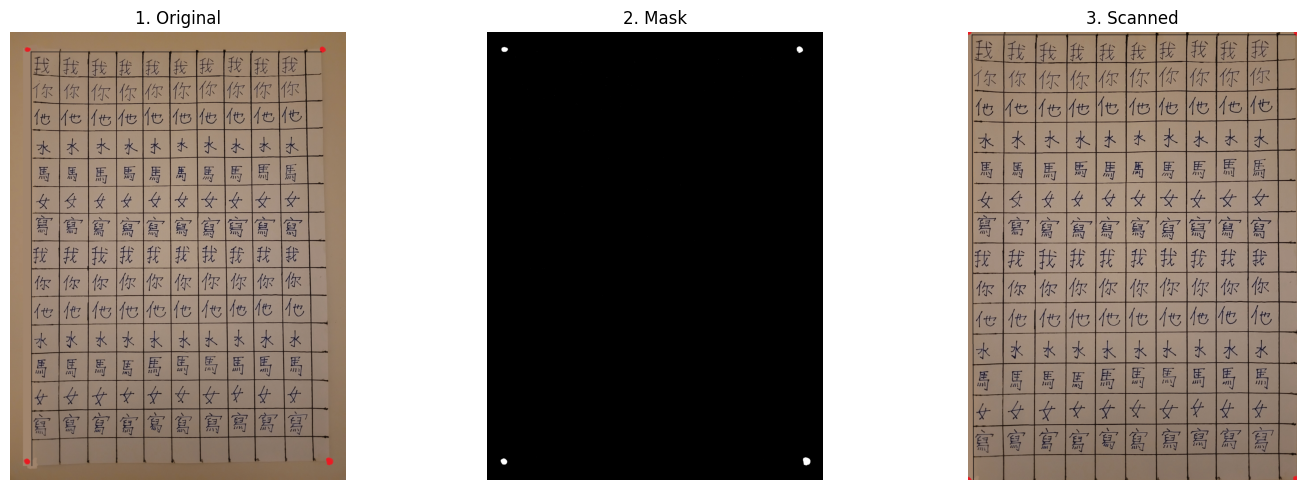

In [10]:

def order_points(pts):
	"""
	This function orders four random points in a clockwise cicle
	"""
	rect = np.zeros((4, 2), dtype="float32")

	# the top-left point => smallest sum
	# the bottom-right point => largest sum
	s = pts.sum(axis=1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]

	# top-right point => negative difference (y - x)
	# bottom-left point => largest difference (y - x)
	diff = np.diff(pts, axis=1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]

	return rect

def scan_image(file_name, file_dir, show=False):
	### Perform image warp ###
	# 1. Load the image
	full_path = os.path.join(file_dir, file_name)
	img = cv2.imread(full_path)
	orig_img = img.copy()

	# 2. Convert to HSV color space
	hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

	# 3. Define range for red color
	# Red wraps around the 0-180 hue scale
	# Lower red range (e.g., 0-10)
	lower_red1 = np.array([0, 120, 70])
	upper_red1 = np.array([10, 255, 255])
	mask1 = cv2.inRange(hsv, lower_red1, upper_red1)

	# Upper red range (e.g., 170-180)
	lower_red2 = np.array([170, 120, 70])
	upper_red2 = np.array([180, 255, 255])
	mask2 = cv2.inRange(hsv, lower_red2, upper_red2)

	# Combine the two masks
	mask = mask1 + mask2


	# 4. Find contours in the mask
	contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

	if len(contours) >= 4:
		# Take 4 largest contours (disregard noise)
		contours = sorted(contours, key=cv2.contourArea, reverse=True)[:4]
		
		points = []
		for c in contours:
			# Get the center of the contour
			M = cv2.moments(c)
			if M["m00"] != 0:
				cX = int(M["m10"] / M["m00"])
				cY = int(M["m01"] / M["m00"])
				points.append([cX, cY])
			
		points = np.array(points, dtype="float32")
		
		# 5. Order the points
		rect = order_points(points)
		(tl, tr, br, bl) = rect
		
		# 6. Apply image warp
		# Compute the width of the new image
		widthA = np.linalg.norm(br - bl)
		widthB = np.linalg.norm(tr - tl)
		maxWidth = max(int(widthA), int(widthB))
		
		# Compute the height of the new image
		heightA = np.linalg.norm(tr - br)
		heightB = np.linalg.norm(tl - bl)
		maxHeight = max(int(heightA), int(heightB))
		
		# Define the destination points
		# -1 because of 0 indexed
		dst = np.array([
			[0, 0],
			[maxWidth - 1, 0],
			[maxWidth - 1, maxHeight - 1],
			[0, maxHeight - 1]], dtype="float32")
		
		# Compute the perspective transform matrix
		M = cv2.getPerspectiveTransform(rect, dst)
		
		# Apply the perspective warp
		warped = cv2.warpPerspective(orig_img, M, (maxWidth, maxHeight))
		
		# Save the final "scanned" image
		base_name, extension = os.path.splitext(file_name)
		save_path = os.path.join(file_dir, base_name + '_scan' + extension)
		cv2.imwrite(save_path, warped)

		if show:
			fig, axes = plt.subplots(1, 3, figsize=(15, 5)) # (width, height)
			# 2. Plot on the first subplot (axes[0])
			axes[0].imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
			axes[0].set_title('1. Original')
			axes[0].axis('off')

			# 3. Plot on the second subplot (axes[1])
			axes[1].imshow(mask, cmap='gray')
			axes[1].set_title('2. Mask')
			axes[1].axis('off')

			# 4. Plot on the third subplot (axes[2])
			axes[2].imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
			axes[2].set_title('3. Scanned')
			axes[2].axis('off')

			# 5. Show the plot
			plt.tight_layout()

	else:
		print("Could not find 4 red dots. Try adjusting the HSV red ranges.")

file_dir = 'data'
file_name = 'sheet1.jpg'
scan_image(file_dir=file_dir, file_name=file_name, show=True)

### Detect straight lines in image

In [11]:
def is_cluster_length_valid(lines, img_len, axis='horizontal', tolerance=0.05):
	"""
	lines: np.array of shape (N,4) - (x0,y0,x1,y1)
	img_len: length (pixels) of current axis of image
	axis: 'horizontal' or 'vertical'
	tolerance: how much percent shorter can line be than img_len to be accepted
	"""
	if axis == 'horizontal':
		intervals = [(min(x0, x1), max(x0, x1)) for (x0, _, x1, _) in lines] # x0, y0, x1, y1
	else:
		intervals = [(min(y0, y1), max(y0, y1)) for (_, y0, _, y1) in lines] # x0, y0, x1, y1
	intervals.sort(key=lambda x: x[0])

	merged = []
	for start, end in intervals:
		if not merged or start > merged[-1][1]:
			merged.append([start, end])
		else:
			merged[-1][1] = max(merged[-1][1], end)

	covered_length = sum(end - start for start, end in merged)
	if covered_length >= (1 - tolerance) * img_len:
		return True
	return False


def cluster_lines(lines, img_len, axis='horizontal', eps=5, tolerance=0.05):
	"""
	lines: np.array of shape (N,4) - (x0,y0,x1,y1)
	img_len: int depicting length (pixels) of current axis of image
	axis: 'horizontal' or 'vertical'
	eps: maximum distance for DBSCAN
	tolerance: how much percent shorter can line be than img_len to be accepted
	"""
	if axis == 'horizontal':
			coords = (lines[:,1] + lines[:,3]) / 2
	else:
		coords = (lines[:,0] + lines[:,2]) / 2

	coords = coords.reshape(-1,1)
	clustering = DBSCAN(eps=eps, min_samples=1).fit(coords)
	labels = clustering.labels_

	clustered_lines = []
	for label in np.unique(labels):
		cluster = lines[labels == label]
		if is_cluster_length_valid(cluster, img_len, axis=axis, tolerance=tolerance):
			if axis == 'horizontal':
				y = np.mean((cluster[:,1] + cluster[:,3]) / 2)
				x0 = np.min(cluster[:,[0,2]])
				x1 = np.max(cluster[:,[0,2]])
				avg_line = [x0, y, x1, y]
			else:
				x = np.mean((cluster[:,0] + cluster[:,2]) / 2)
				y0 = np.min(cluster[:,[1,3]])
				y1 = np.max(cluster[:,[1,3]])
				avg_line = [x, y0, x, y1]
			clustered_lines.append(avg_line)

	return np.array(clustered_lines).astype(int)


def draw_lines(img, lines):
	"""
	img: image with BGR channels
	lines: np.array of shape (N,4) - (x0,y0,x1,y1)
	"""
	line_img = np.copy(img)
	if lines is not None:
		for (x0, y0, x1, y1) in lines:
			cv2.line(line_img, (int(x0), int(y0)), (int(x1), int(y1)), (0, 0, 255), 3, cv2.LINE_AA)

	plt.imshow(cv2.cvtColor(line_img, cv2.COLOR_BGR2RGB))
	plt.axis('off')
	plt.show()


In [12]:
def detect_lines(img, eps=10, tolerance=0.2, show=False):
	"""
	img: image with BGR channels
	eps: maximum distance for DBSCAN
	tolerance: how much percent shorter can line be than img_len to be accepted
	show: boolean if image should be shown with lines inside
	"""

	# Detect all edges in image
	edge_img = cv2.Canny(img, 30, 150, None, 3)

	# Dilate edges to merge close ones
	kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
	edge_img = cv2.dilate(edge_img, kernel)

	# Detect all lines using Houghs line transformation
	lines = cv2.HoughLinesP(edge_img, 1, np.pi / 180, 50, None, 50, 10) # e.g. (962, 1, 4)
	lines = lines.squeeze(axis=1)  # shape: (962, 4) (x0,y0,x1,y1)

	# Calculate angle for all lines
	angles = np.arctan2(lines[:,3] - lines[:,1], lines[:,2] - lines[:,0])
	angles_deg = np.degrees(angles)  # -180° to 180°
	horizontal_lines = lines[np.abs(angles_deg) < 10] # near 0°
	vertical_lines   = lines[np.abs(np.abs(angles_deg) - 90) < 10] # near 90°

	# Merge all broken lines and select the ones that are the grid lines
	vertical_len, horizontal_len, _ = img.shape
	horizontal_lines = cluster_lines(horizontal_lines, img_len=horizontal_len, axis="horizontal", eps=eps, tolerance=tolerance)
	vertical_lines = cluster_lines(vertical_lines, img_len=vertical_len, axis="vertical", eps=eps, tolerance=tolerance)

	if show:
		draw_lines(img, vertical_lines)
		draw_lines(img, horizontal_lines)

	return vertical_lines, horizontal_lines

In [ ]:

def split_img_into_cells(img, vertical_lines, horizontal_lines, show=False):
	# Sort all x and y coordinates of all grid lines
	xs = sorted(set([int((line[0] + line[2]) / 2) for line in vertical_lines]))
	ys = sorted(set([int((line[1] + line[3]) / 2) for line in horizontal_lines]))
	num_rows = len(ys) - 1
	num_cols = len(xs) - 1
	# Create array of cells
	cells = np.empty([num_rows, num_cols], dtype=object)
	for i in range(num_rows):
		for j in range(num_cols):
			x0, x1 = xs[j], xs[j+1]
			y0, y1 = ys[i], ys[i+1]
			cell = img[y0:y1, x0:x1]
			cells[i, j] = cell


	# Postprocess cells (resize, grascale)
	fixed_size = (32, 32) # width, height
	   
	# Iterate through the 2D list of cells, process, and replace the original slice with the processed cell
	for i in range(num_rows):
		for j in range(num_cols):
			cells[i][j] = cv2.resize(cv2.cvtColor(cells[i][j], cv2.COLOR_BGR2GRAY), fixed_size, interpolation=cv2.INTER_AREA)

	if show:
		flat_cells = [cell for row in cells for cell in row]
		plt.figure(figsize=(num_cols, num_rows)) # width, height
		for idx, cell in enumerate(flat_cells):
			plt.subplot(num_rows, num_cols, idx+1)
			plt.imshow(cell, cmap='gray')
			plt.axis('off')
		plt.tight_layout()
		plt.show()

	return cells	


Width: 2724 Height: 3709


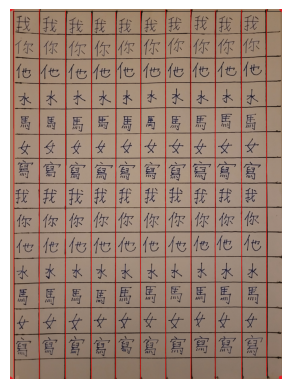

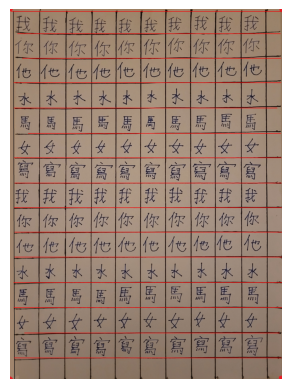

(14, 10)
i 0 j 0
i 0 j 1
i 0 j 2
i 0 j 3
i 0 j 4
i 0 j 5
i 0 j 6
i 0 j 7
i 0 j 8
i 0 j 9
i 1 j 0
i 1 j 1
i 1 j 2
i 1 j 3
i 1 j 4
i 1 j 5
i 1 j 6
i 1 j 7
i 1 j 8
i 1 j 9
i 2 j 0
i 2 j 1
i 2 j 2
i 2 j 3
i 2 j 4
i 2 j 5
i 2 j 6
i 2 j 7
i 2 j 8
i 2 j 9
i 3 j 0
i 3 j 1
i 3 j 2
i 3 j 3
i 3 j 4
i 3 j 5
i 3 j 6
i 3 j 7
i 3 j 8
i 3 j 9
i 4 j 0
i 4 j 1
i 4 j 2
i 4 j 3
i 4 j 4
i 4 j 5
i 4 j 6
i 4 j 7
i 4 j 8
i 4 j 9
i 5 j 0
i 5 j 1
i 5 j 2
i 5 j 3
i 5 j 4
i 5 j 5
i 5 j 6
i 5 j 7
i 5 j 8
i 5 j 9
i 6 j 0
i 6 j 1
i 6 j 2
i 6 j 3
i 6 j 4
i 6 j 5
i 6 j 6
i 6 j 7
i 6 j 8
i 6 j 9
i 7 j 0
i 7 j 1
i 7 j 2
i 7 j 3
i 7 j 4
i 7 j 5
i 7 j 6
i 7 j 7
i 7 j 8
i 7 j 9
i 8 j 0
i 8 j 1
i 8 j 2
i 8 j 3
i 8 j 4
i 8 j 5
i 8 j 6
i 8 j 7
i 8 j 8
i 8 j 9
i 9 j 0
i 9 j 1
i 9 j 2
i 9 j 3
i 9 j 4
i 9 j 5
i 9 j 6
i 9 j 7
i 9 j 8
i 9 j 9
i 10 j 0
i 10 j 1
i 10 j 2
i 10 j 3
i 10 j 4
i 10 j 5
i 10 j 6
i 10 j 7
i 10 j 8
i 10 j 9
i 11 j 0
i 11 j 1
i 11 j 2
i 11 j 3
i 11 j 4
i 11 j 5
i 11 j 6
i 11 j 7
i 11 j 8
i 11 j 9
i 12 j 0
i 

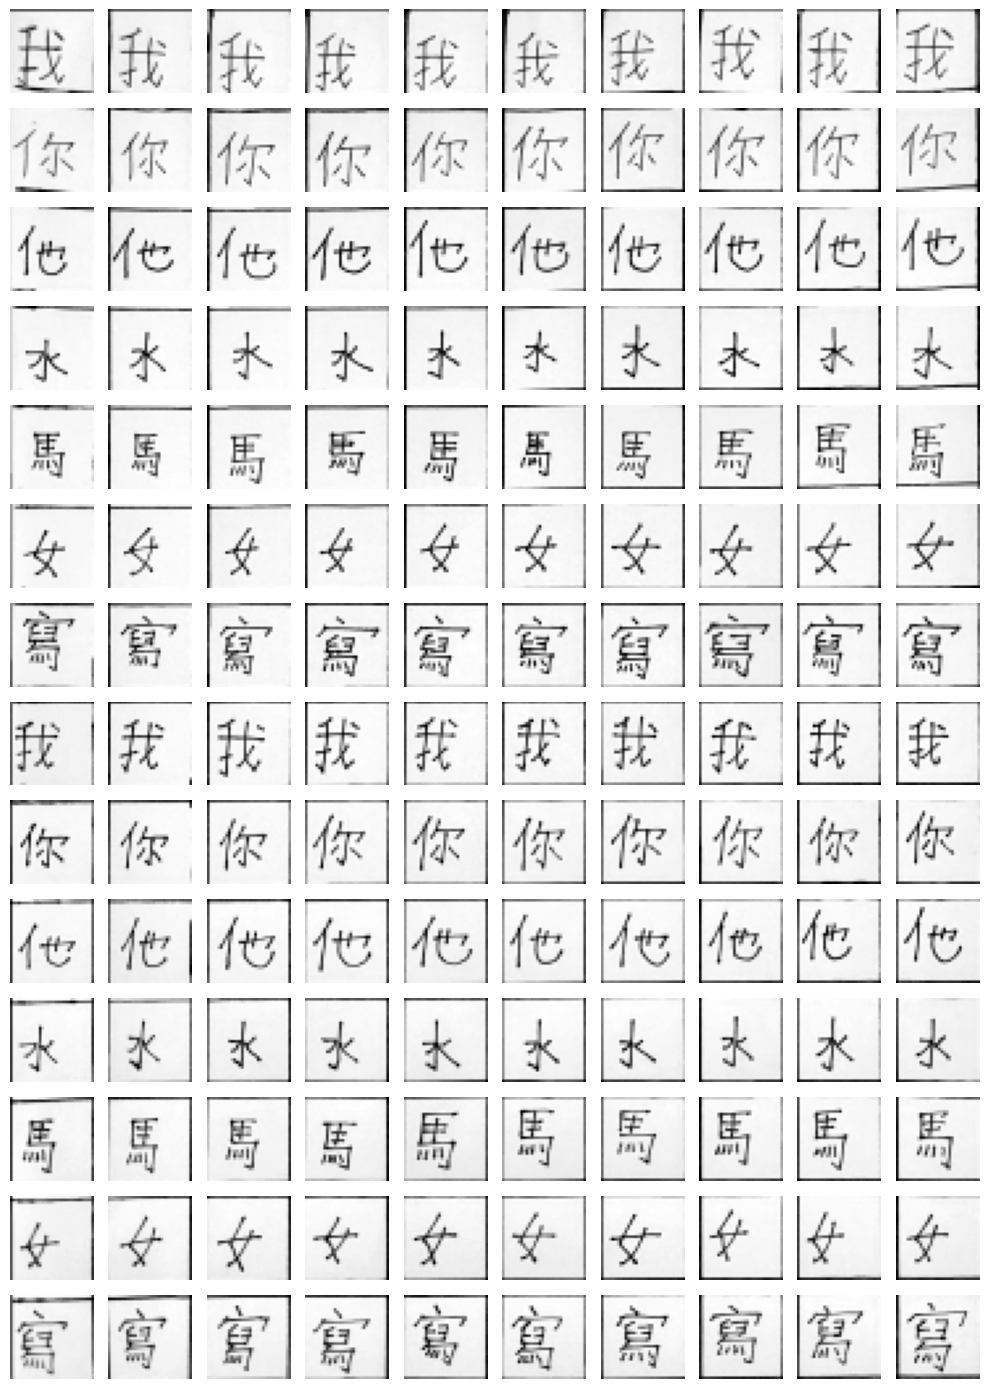

In [15]:



labels = ['I', 'YOU', 'HE', 'WATER', 'HORSE', 'FEMALE', 'WRITE']
iters = 2
file_dir = 'data'
file_name = 'sheet1_scan.jpg'
file_path = os.path.join(file_dir, file_name)
dataset_dir = 'hanzi_dataset'



# Split scanned image into cells
img = cv2.imread(file_path) # BGR channels
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
height, width = img.shape[:2]
print("Width:", width, "Height:", height)
vertical_lines, horizontal_lines = detect_lines(img, show=True)
cells = split_img_into_cells(img, vertical_lines, horizontal_lines, True)


### Save cells in folder structure ##
os.makedirs(dataset_dir, exist_ok=True)

for iter in range(iters):
	idx_counter = Counter(labels)
	# 1. Adjust counters to current filenum
	for i, label in enumerate(labels):
		row_idx =  i + (iter * len(labels))
		label_dir = os.path.join(dataset_dir, label)
		os.makedirs(label_dir, exist_ok=True)
		dir_list = os.listdir(label_dir)
		idx_counter[label] = len(dir_list) # Set counter to n elements for label
		row = cells[row_idx, :]
		
		# 2. Save each cell in a row
		for cell in row:
			file_name = label + '_' + str.zfill(str(idx_counter[label]), 3) + '.jpg'
			save_path = os.path.join(label_dir, file_name)
			cv2.imwrite(save_path, cell)
			idx_counter[label] += 1 # Increase counter



